In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(
    {
        "text.usetex": True,
        "axes.labelsize": 20,
        "figure.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "figure.constrained_layout.wspace": 0,
        "figure.constrained_layout.hspace": 0,
        "figure.constrained_layout.h_pad": 0,
        "figure.constrained_layout.w_pad": 0,
        "axes.linewidth": 1.3,
    }
)

import jax

# you should always set this
jax.config.update("jax_enable_x64", True)

## Multiband GP Fitting
This notebook present a complete workflow on how to perform multiband fitting using `EzTaoX`. A damped random walk (DRW) GP kernel is assumed. 

### 1. Light Curve Simulation
We first simulate DRW light curves in two different bands. The intrinsic DRW timescales are set to be the same across bands, and the amplitudes are set to differ. We also add a five-day time delay between these two bands.

In [2]:
# we use eztao to perform the simulation
from eztao.carma import DRW_term
from eztao.ts import addNoise, gpSimRand

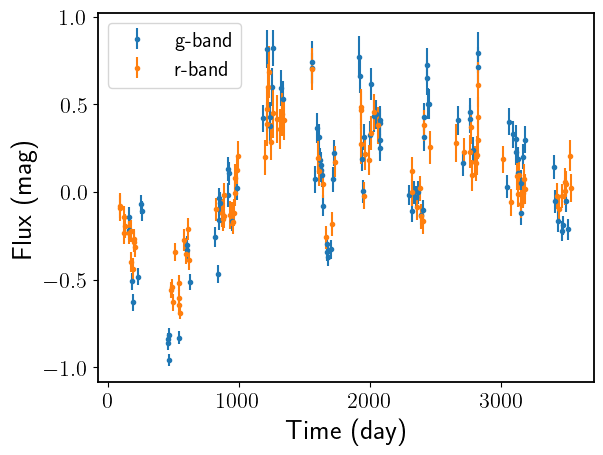

In [3]:
amps = {"g": 0.35, "r": 0.25}
taus = {"g": 100, "r": 100}
snrs = {"g": 5, "r": 3} # ratio of the DRW amplitude to the median error bar
sampling_seeds = {"g": 2, "r": 5} # seed for random sampling
noise_seeds = {"g": 111, "r": 2} # seed for mocking observational noise

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 2
for band in "gr":
    DRW_kernel = DRW_term(np.log(amps[band]), np.log(taus[band]))
    t, y, yerr = gpSimRand(
        DRW_kernel,
        snrs[band],
        365 * 10, # 10 year LC
        100,
        lc_seed=seed,
        downsample_seed=sampling_seeds[band]
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    # add simulated photometric noise
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

## add time lag
ts['r'] += 5

for b in "gr":
    plt.errorbar(ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".", label=f'{b}-band')

plt.xlabel('Time (day)')
plt.ylabel('Flux (mag)')
plt.legend(fontsize=15)

### 2. Light Curve Formatting

To fit multi-band data, you need to put the LCs into a specific format. If your LC are stored in a dictionary (with the key being the band name), see example in Section I, you can use the following function to format it. The output are X, y, yerr:

- **X**: A tuple of arrays in the format of (time, band index)
    - *time*: An array of time stamps for observations in all bands.
    - *band index*: An array of integers, starting with 0. This array has the same size as the *time* array. Observations with the band index belong to the same band. Band assigned with a band index of 0 is treated as the 'reference' band. 
- **y**: An array of observed values (from all bands).
- **yerr**: An array observational uncertainties associated with **y**.

In [4]:
from eztaox.ts_utils import formatlc

In [5]:
band_index = {"g": 0, "r": 1}
X, y, yerr = formatlc(ts, ys_noisy, yerrs, band_index)
X, y, yerr

((Array([ 159.5209521 ,  160.61606161,  187.62876288,  192.37423742,
          227.41774177,  252.24022402,  263.55635564,  456.66066607,
          462.13621362,  466.88168817,  468.34183418,  541.34913491,
          607.78577858,  608.15081508,  631.87818782,  820.96709671,
          842.13921392,  849.43994399,  850.53505351,  859.29592959,
          921.35213521,  922.08220822,  925.73257326,  947.26972697,
          987.05870587, 1187.09870987, 1212.65126513, 1237.47374737,
         1237.83878388, 1254.99549955, 1261.20112011, 1321.43214321,
         1341.87418742, 1558.34083408, 1561.26112611, 1580.97309731,
         1597.76477648, 1616.38163816, 1620.76207621, 1627.69776978,
         1628.42784278, 1633.17331733, 1643.02930293, 1670.4070407 ,
         1675.88258826, 1682.08820882, 1702.53025303, 1723.33733373,
         1725.16251625, 1917.90179018, 1925.56755676, 1941.26412641,
         1949.659966  , 1956.23062306, 2004.05040504, 2012.44624462,
         2031.79317932, 2047.85478

### 3. The Inference Interface
Classes included in the `eztaox.models` module constitute the main interface for performing light curve modeling. 

In [6]:
import jax.numpy as jnp
from eztaox.kernels.quasisep import Exp, MultibandLowRank
from eztaox.models import MultiVarModel
from eztaox.fitter import random_search
import numpyro
from numpyro.handlers import seed as numpyro_seed
import numpyro.distributions as dist

#### 3.1 Initialize a light curve model

In [7]:
# define model parameters
has_lag = True # if fit interband lags
zero_mean = True # if fit a mean function
nBand = 2 # number of bands in the provide light curve (X, y, yerr)

# initialize a GP kernel, note the initial parameters are not used in the fitting
k = Exp(scale=100.0, sigma=1.0)
m = MultiVarModel(X, y, yerr, k, nBand, has_lag=has_lag, zero_mean=zero_mean)
m

MultiVarModel(
  X=(f64[200], i64[200]),
  y=f64[200],
  diag=f64[200],
  base_kernel_def=<jax._src.util.HashablePartial object at 0xffff186d14c0>,
  multiband_kernel=<class 'eztaox.kernels.quasisep.MultibandLowRank'>,
  nBand=2,
  mean_func=None,
  amp_scale_func=None,
  lag_func=None,
  zero_mean=True,
  has_jitter=False,
  has_lag=True
)

#### 3.2 Maximum Likelihood (MLE) Fiting

To find the best-fit parameters, one can start at a random point in the parameter space and optimize the likelihood function until it stops changing. This likelihood function given a set of new parameters can be obtained by calling `MutliVarModel.log_prob(params)`. However, I find this approach often stuck in local minima. `EzTaoX` provides a fitter function (`random_search`) to alleviate this issue (to some level). The `random_search` function first does a random search (i.e., evaluate the likelihood at a large number of randomly chosen positions in the parameter space) and then select a few (defaults to five) positions with the highest likelihood to proceed with additional non-linear optimization (e.g., using L-BFGS-B).

The `random_search` function takes the following arguments:
- **model**: an instance of `MultiVarModel`
- **initSampler**: a custom function (you need to provide) for generating random samples for the random search step.
- **prng_key**: a `JAX` random number generator key.
- **nSample**: number of random samples to draw.
- **nBest**: number of best samples to keep for continued optimization.
- **jaxoptMethod**: fine optimization method to use. => see [**here**](https://jaxopt.github.io/stable/_autosummary/jaxopt.ScipyMinimize.html#jaxopt.ScipyMinimize.method) for supported methods.
- **batch_size**: The number of likelihood to evaluate each time. Defaults to 1000, for simpler models (and if you have enough memory), you can set this to `nSample`.

#### InitSampler
The `initSampler` defines a prior distribution from which to draw random samples to evaluate the likelihood. It shares a similar structure as that used to perform MCMC using `numpyro` (see Section 4). The distribution for a parameter can take any shapes, as long as it has a `numpyro` implementation. A list of `numpyro` distributions can be found [here](https://num.pyro.ai/en/stable/distributions.html). 

In [8]:
def initSampler():
    # GP kernel param
    log_drw_scale = numpyro.sample(
        "drw_scale", dist.Uniform(jnp.log(0.01), jnp.log(1000))
    )
    log_drw_sigma = numpyro.sample(
        "drw_sigma", dist.Uniform(jnp.log(0.01), jnp.log(10))
    )
    log_kernel_param = jnp.stack([log_drw_scale, log_drw_sigma])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # parameters to relate the amplitudes in each band
    log_amp_scale = numpyro.sample("log_amp_scale", dist.Uniform(-2, 2))

    mean = numpyro.sample(
        "mean", dist.Uniform(low=jnp.asarray([-.1, -.1]), 
                             high=jnp.asarray([.1, .1]))
    )

    # interband lags
    lag = numpyro.sample("lag", dist.Uniform(-10, 10))

    sample_params = {
        "log_kernel_param": log_kernel_param,
        "log_amp_scale": log_amp_scale,
        "mean": mean,
        "lag": lag
    }

    return sample_params

In [9]:
# generate a random initial guess
sample_key = jax.random.PRNGKey(1)
prior_sample = numpyro_seed(initSampler, rng_seed=sample_key)()
prior_sample

{'log_kernel_param': Array([-2.19138685,  0.3506587 ], dtype=float64),
 'log_amp_scale': Array(-0.62220133, dtype=float64),
 'mean': Array([-0.04758097,  0.00985753], dtype=float64),
 'lag': Array(-1.42400368, dtype=float64)}

#### **A note on model parameters**:
- **`log_kernel_param`**: The parameters of the latent GP process. 
- **`log_amp_scale`**: This parameter characterize the log of the ratio between the amplitude of the GP in each band relative to the latent GP (i.e., the $S$ parameter in the kernel function). Since the $S$ parameter is set to 1 by default, `log_amp_scale` is an array of size M-1, where M is the number of bands.
- **`mean`**: The mean of the light curve in each band, with a size M. 
- **`lag`**: The inter-band lags with respect to the reference band. `lag` is any array with a size M-1

#### Try MLE Fitting

In [10]:
%%time
model = m
sampler = initSampler
fit_key = jax.random.PRNGKey(1)
nSample = 1_000
nBest = 5  # it seems like this number needs to be high

bestP, ll = random_search(model, initSampler, fit_key, nSample, nBest)
bestP

CPU times: user 1.06 s, sys: 105 ms, total: 1.17 s
Wall time: 1.12 s


{'lag': Array(4.52636833, dtype=float64),
 'log_amp_scale': Array(-0.36708154, dtype=float64),
 'log_kernel_param': Array([ 4.96865179, -0.83999754], dtype=float64),
 'mean': Array([-0.06478577,  0.0316729 ], dtype=float64)}

### 4.0 MCMC
MCMC sampling is carried out using the `numpyro` package, which is native to `JAX`. In this example, I will use the NUTS algorithm, however, there are a large collection of sampling algorithms that you can pick from (see [here](https://num.pyro.ai/en/stable/infer.html)). In addition, you can freely specify more flexible (no longer just flat!!) prior distributions for each parameter in the light curve model. 

#### Define `numpyro` MCMC model

In [11]:
def numpyro_model(X, yerr, y=None):
    # GP kernel param
    log_drw_scale = numpyro.sample(
        "log_drw_scale", dist.Uniform(jnp.log(0.01), jnp.log(1000))
    )
    log_drw_sigma = numpyro.sample(
        "log_drw_sigma", dist.Uniform(jnp.log(0.01), jnp.log(10))
    )
    log_kernel_param = jnp.stack([log_drw_scale, log_drw_sigma])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # parameters to relate the amplitudes in each band
    log_amp_scale = numpyro.sample("log_amp_scale", dist.Uniform(-2, 2))

    mean = numpyro.sample(
        "mean", dist.Uniform(low=jnp.asarray([-.1, -.1]), 
                             high=jnp.asarray([.1, .1]))
    )

    # interband lags
    lag = numpyro.sample("lag", dist.Uniform(-10, 10))

    sample_params = {
        "log_kernel_param": log_kernel_param,
        "log_amp_scale": log_amp_scale,
        "mean": mean,
        "lag": lag
    }    

    ## the following is different from the initSampler
    has_lag = True
    zero_mean = True
    nBand = 2

    k = Exp(scale=100.0, sigma=1.0) # init params for k are not used
    m = MultiVarModel(X, y, yerr, k, nBand, has_lag=has_lag, zero_mean=zero_mean)
    m.sample(sample_params)

#### Run MCMC

In [12]:
from numpyro.infer import MCMC, NUTS, init_to_median
import arviz as az

In [13]:
%%time
nuts_kernel = NUTS(
    numpyro_model,
    dense_mass=True,
    target_accept_prob=0.9,    
    init_strategy=init_to_median,
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    # progress_bar=False,
)

mcmc_seed = 0
mcmc.run(jax.random.PRNGKey(mcmc_seed), X, yerr, y=y)
data = az.from_numpyro(mcmc)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:03<00:00, 466.33it/s, 15 steps of size 2.81e-01. acc. prob=0.94] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
            lag      4.24      1.24      4.34      2.08      6.08    764.91      1.00
  log_amp_scale     -0.37      0.05     -0.37     -0.45     -0.29    979.82      1.00
  log_drw_scale      5.15      0.47      5.08      4.41      5.80    221.29      1.00
  log_drw_sigma     -0.76      0.21     -0.79     -1.08     -0.45    213.91      1.00
        mean[0]     -0.00      0.06     -0.00     -0.09      0.08    896.73      1.00
        mean[1]     -0.00      0.06     -0.00     -0.09      0.09    876.34      1.00

Number of divergences: 0
CPU times: user 6.09 s, sys: 361 ms, total: 6.45 s
Wall time: 6.72 s


#### Visualize Chains, Posterior Distributions

In [14]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

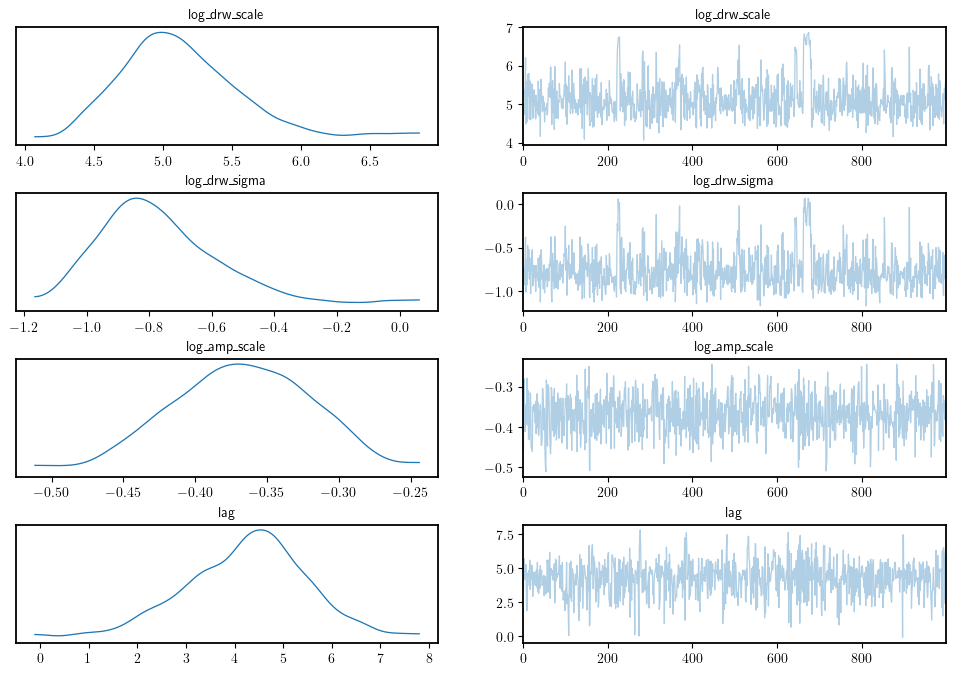

In [15]:
az.plot_trace(data, var_names=['log_drw_scale', 'log_drw_sigma', 'log_amp_scale', 'lag'])
plt.subplots_adjust(hspace=0.4)

array([[<Axes: ylabel='log_drw_sigma'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_amp_scale'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='log_drw_scale', ylabel='lag'>,
        <Axes: xlabel='log_drw_sigma'>, <Axes: xlabel='log_amp_scale'>]],
      dtype=object)

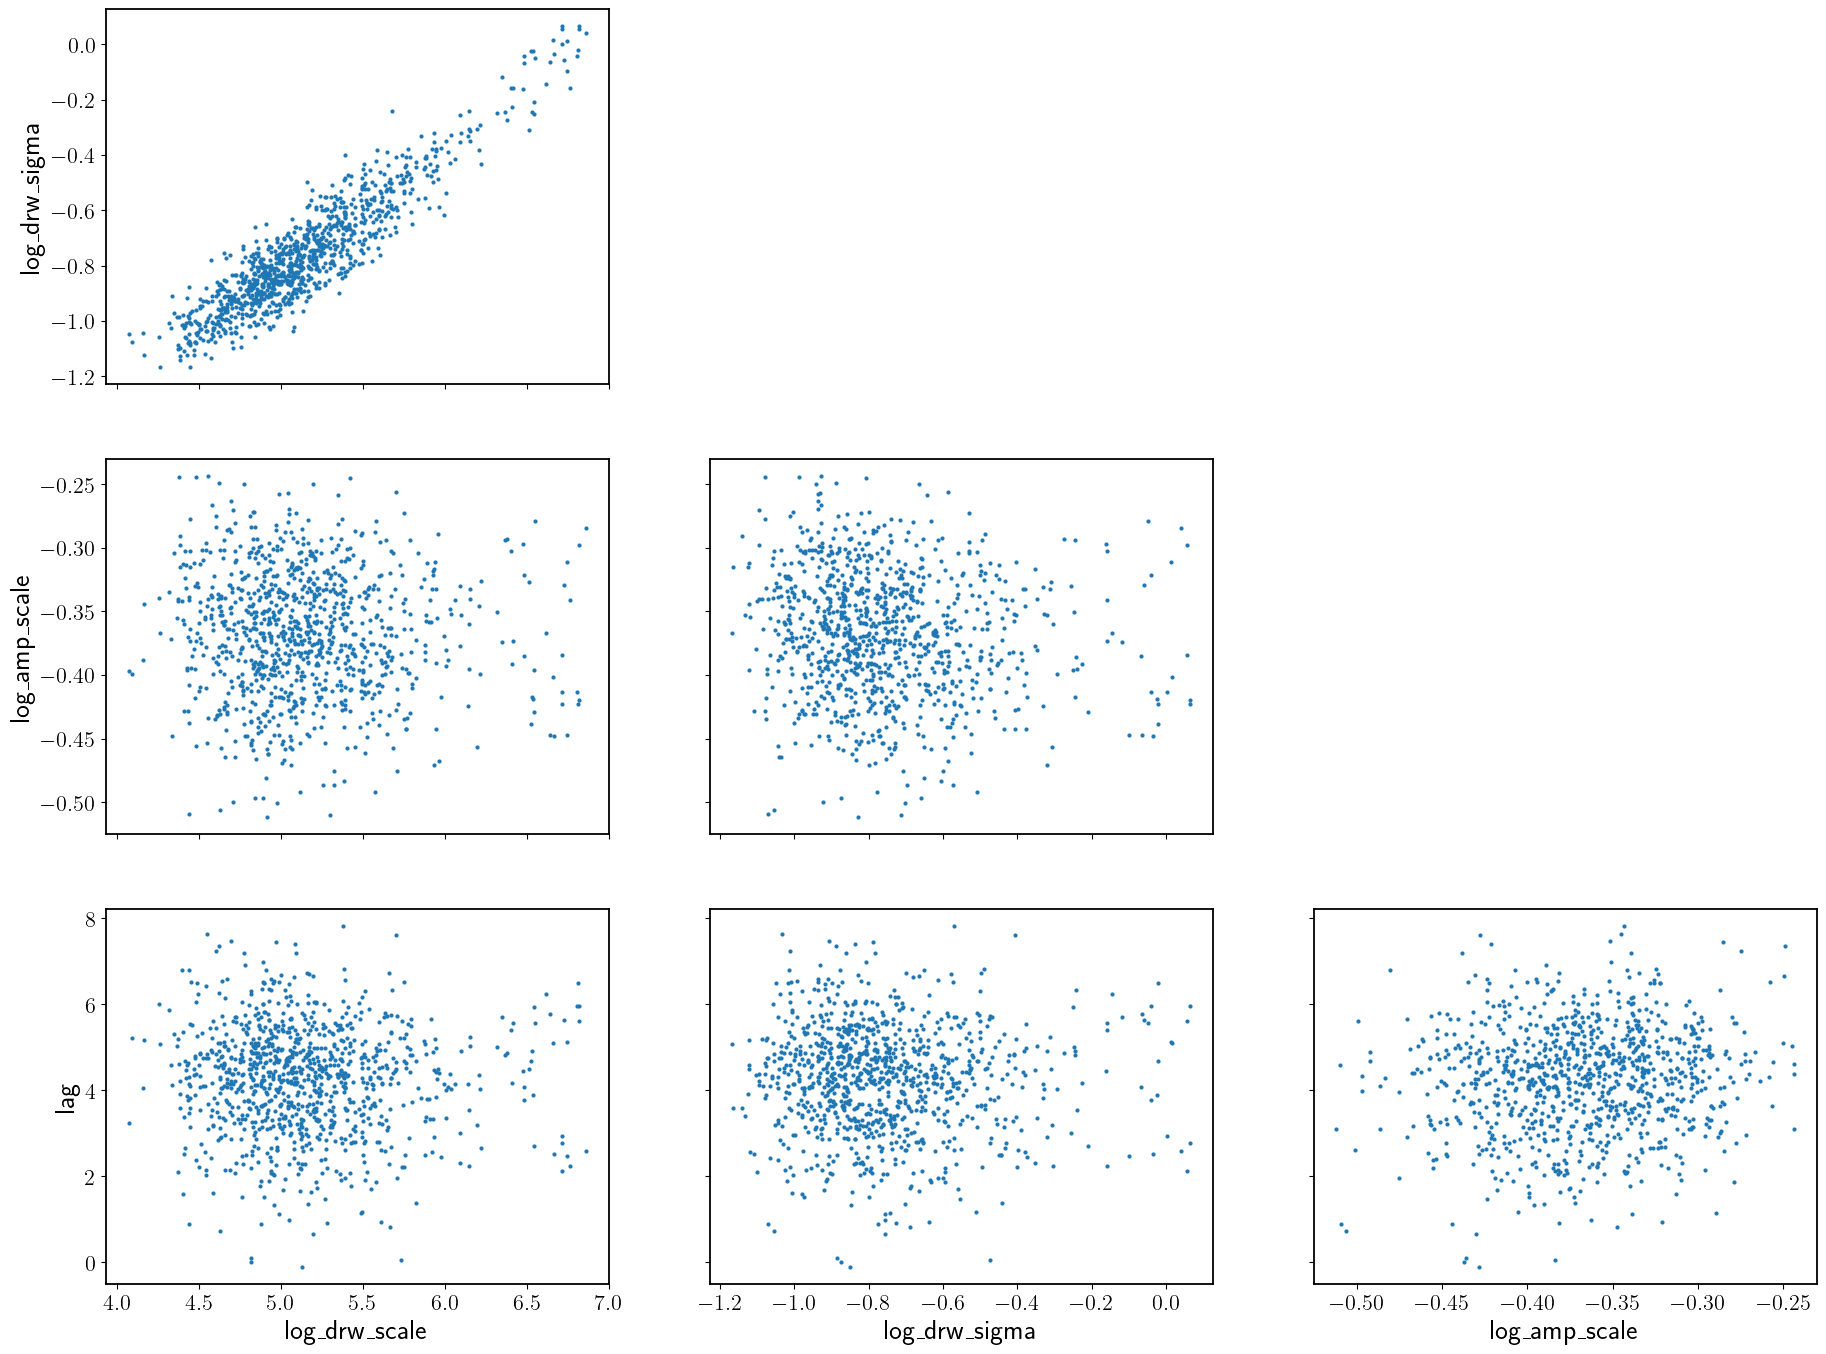

In [16]:
az.plot_pair(data, var_names=['log_drw_scale', 'log_drw_sigma', 'log_amp_scale', 'lag'])

### 5.0 Second-order Statistics
`EzTaoX` provides a unified class (`extaox.kernel_stat2.gpStat2`) for generating the second-order statistic functions (ACF, SF, and PSD) of any supported kernels. All you need to do is initialize a `gpStat2` instance with your desired kernel. 

In [17]:
from eztaox.kernel_stat2 import gpStat2

In [18]:
ts = np.logspace(-1, 3)
fs = np.logspace(-3, 3)

#### 5.1 Get MCMC Samples

In [19]:
flatPost = data.posterior.stack(sample=["chain", "draw"])

log_drw_draws = flatPost['log_kernel_param'].values.T
log_amp_scale_draws = flatPost['log_amp_scale'].values.T
lag_draws = flatPost['lag'].values.T

#### 5.2 `g`-band SF

In [20]:
# create a 2nd statistic object using the true g-band kernel
g_drw = Exp(scale=taus['g'], sigma=amps['g'])
gpStat2_g = gpStat2(g_drw)

# compute sf for MCMC draws
mcmc_sf_g = jax.vmap(gpStat2_g.sf, in_axes=(None, 0))(ts, jnp.exp(log_drw_draws))

Text(0, 0.5, 'SF')

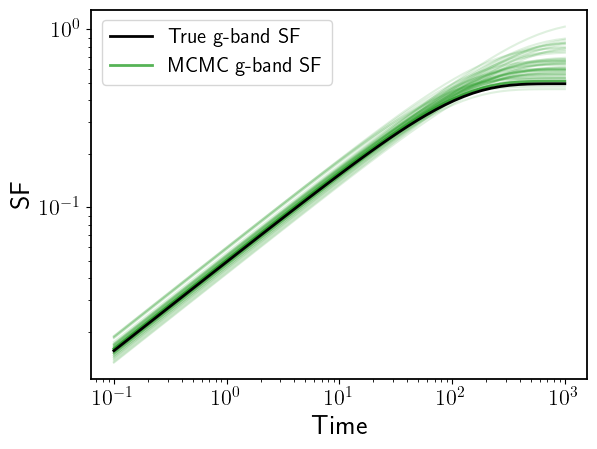

In [21]:
## plot
# ture SF
plt.loglog(ts, gpStat2_g.sf(ts), c='k', label='True g-band SF', zorder=100, lw=2)
plt.loglog(ts, mcmc_sf_g[0], label='MCMC g-band SF', c='tab:green', alpha=0.8, lw=2)
plt.legend(fontsize=15)
# MCMC SFs
for sf in mcmc_sf_g[::20]:
    plt.loglog(ts, sf, c='tab:green', alpha=0.15)

plt.xlabel('Time')
plt.ylabel('SF')

#### 5.3 `r`-band SF

In [22]:
# create a 2nd statistic object using the true g-band kernel
r_drw = Exp(scale=taus['r'], sigma=amps['r'])
gpStat2_r = gpStat2(r_drw)

# compute sf for MCMC draws
log_drw_draws_r = log_drw_draws.copy()
log_drw_draws_r[:, 1] += log_amp_scale_draws
mcmc_sf_r = jax.vmap(gpStat2_r.sf, in_axes=(None, 0))(ts, jnp.exp(log_drw_draws_r))

Text(0, 0.5, 'SF')

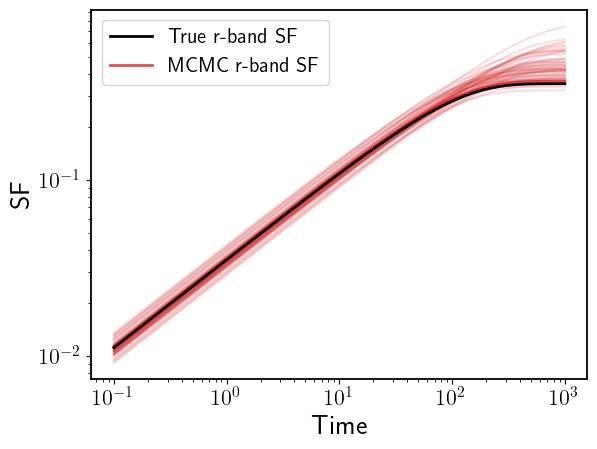

In [23]:
## plot
# ture SF
plt.loglog(ts, gpStat2_r.sf(ts), c='k', label='True r-band SF', zorder=100, lw=2)
plt.loglog(ts, mcmc_sf_r[0], label='MCMC r-band SF', c='tab:red', alpha=0.8, lw=2)
plt.legend(fontsize=15)
# MCMC SFs
for sf in mcmc_sf_r[::20]:
    plt.loglog(ts, sf, c='tab:red', alpha=0.15)

plt.xlabel('Time')
plt.ylabel('SF')

### 6.0 Lag distribution

(0.0, 0.4)

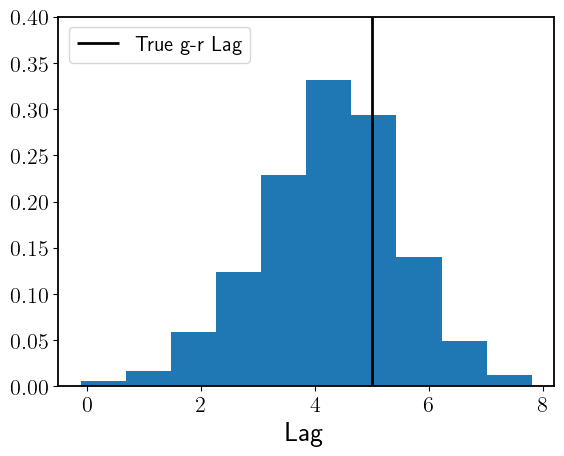

In [24]:
_ = plt.hist(lag_draws, density=True)
plt.vlines(5.0, ymin=0, ymax=0.4, color='k', lw=2, label='True g-r Lag')
plt.legend(fontsize=15, loc=2)

plt.xlabel('Lag')
plt.ylim(0, 0.4)